In [182]:
import torch.nn as nn
import torch
import math
import torch.utils.data as Data
import torch.nn.functional as F
import random
import collections
import matplotlib.pyplot as plt

### bert模型及其组件

In [160]:
def masked_softmax(X, valid_lens=None):
    """通过在最后⼀个轴上遮蔽元素来执⾏softmax操作"""

    def sequence_mask(X, valid_len, value=0):
        """Mask irrelevant entries in sequences"""
        maxlen = X.size(1)
        # 广播机制
        mask = torch.arange(maxlen, device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 被遮蔽的元素使用⼀个非常大的负值替换,使其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)


class DotProductAttention(nn.Module):
    """缩放点积注意力"""

    def __init__(self, dropout):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        # queries.shape = (b, ?q, d)
        # keys.shape = (b, ?k, d)
        # scores.shape = (b, ?q, d) x (b, d, ?k) = (b, ?q, ?k)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values.shape=(b, ?k, ?v)
        # 返回值.shape=(b, ?q, ?k) x (b, ?k, ?v) = (b, ?q, ?v)
        return torch.bmm(self.dropout(self.attention_weights), values)


class MultiHeadAttention(nn.Module):
    """多头注意力"""

    def __init__(self,
                 # 查询特征数目(E_q)
                 query_size,
                 # 键特征数目(E_k)
                 key_size,
                 # 值特征数目(E_v)
                 value_size,
                 # 多头数目
                 num_heads, dropout, bias=False):  # 模仿pytorch的参数组成
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        assert query_size % num_heads == 0, "query_size must be divisible by num_heads"
        # 可学习参数H^2 * 4
        self.W_q = nn.Linear(query_size, query_size, bias=bias)
        self.W_k = nn.Linear(key_size, query_size, bias=bias)
        self.W_v = nn.Linear(value_size, query_size, bias=bias)
        self.W_o = nn.Linear(query_size, query_size, bias=bias)
        self.attention = DotProductAttention(dropout)

    @staticmethod
    def transpose_qkv(X, num_heads):
        # 输入:X.shape=(N, L or S, E_q)
        # X.shape=(N, L or S, num_heads, E_q / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
        # X.shape=(N, num_heads, L or S, E_q / num_heads)
        X = X.permute(0, 2, 1, 3)
        # 返回值.shape=(N * num_heads, L or S, E_q / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def forward(self, queries, keys, values, valid_lens):
        """
        queries: 查询
        keys: 键
        values: 值
        valid_lens: 计算attention_weights的有效长度
        """
        # queries.shape=(N, L, E_q)
        # self.W_q(queries).shape=(N, L, E_q)
        # queries.shape=(N * num_heads, L, E_q / num_heads)

        # keys.shape=(N, S, E_k)
        # self.W_k(queries).shape=(N, S, E_q)
        # keys.shape=(N * num_heads, S, E_q / num_heads)

        # values.shape=(N, S, E_v)
        # self.W_v(values).shape=(N, S, E_q)
        # values.shape=(N * num_heads, S, E_q / num_heads)
        queries = self.transpose_qkv(self.W_q(queries), self.num_heads)
        keys = self.transpose_qkv(self.W_k(keys), self.num_heads)
        values = self.transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # E_q维度信息增加到batch_size维度上
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # output.shape=(N * num_heads, L, E_q / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # output.shape=(N, num_heads, L, E_q / num_heads)
        output = output.reshape(-1, self.num_heads, output.shape[1], output.shape[2])
        # output.shape=(N, L, num_heads, E_q / num_heads)
        output = output.permute(0, 2, 1, 3)
        # output.shape=(N, L, E_q)
        output_concat = output.reshape(output.shape[0], output.shape[1], -1)
        # 返回值.shape=(N, L, E_q)
        return self.W_o(output_concat)


class AddNorm(nn.Module):
    """残差连接和层归一化"""

    def __init__(self,
                 # 除mini-batch维度之外其他维度的列表(即进行层归一化的维度)
                 normalized_shape,
                 dropout):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 原因:句子长度不一致,并且各个batch的信息没什么关系
        self.ln = nn.LayerNorm(normalized_shape)  # Normalized_shape is input.size()[1:]

    def forward(self, X, Y):
        # self.ln内部为残差连接
        return self.ln(self.dropout(Y) + X)


class PositionWiseFFN(nn.Module):
    """Position-wise Feed-Forward Networks"""

    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        # 可学习参数:self.dense1权重矩阵,self.dense2权重矩阵
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


class EncoderBlock(nn.Module):
    """transformer编码器Block"""

    def __init__(self,
                 # 查询特征数目(E_q)
                 query_size,
                 # 键特征数目(E_k)
                 key_size,
                 # 值特征数目(E_v)
                 value_size,
                 # 除mini-batch维度之外其他维度的列表(即进行层归一化的维度)
                 norm_shape,
                 ffn_num_hiddens,
                 # 多头数
                 num_heads, dropout, use_bias=False):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(query_size, key_size, value_size, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 多头注意力`forward`返回值的shape为:(N, L, E_q)
        # 故PositionWiseFFN第一个线性层的输入维度为E_q
        self.ffn = PositionWiseFFN(query_size, ffn_num_hiddens, query_size)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        # transformer编码器Block结构为:
        # =+残差连接=>多头注意力==>add & Norm=+残差连接=>Feed Forward=>add & Norm
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))  # 多头自注意力
        return self.addnorm2(Y, self.ffn(Y))


encoder_blk = EncoderBlock(query_size=24,
                           key_size=24,
                           value_size=24,
                           norm_shape=[100, 24],
                           ffn_num_hiddens=48,
                           num_heads=8,
                           dropout=0.5)
encoder_blk.eval()

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])

# 可以看出Transformer编码器中的任何层都不会改变其输⼊的形状(可叠加多层)
print(encoder_blk(X, valid_lens).shape)

torch.Size([2, 100, 24])


In [161]:
class BERTEncoder(nn.Module):
    """BERT encoder"""

    def __init__(self,
                 # 单词表的单词数目
                 vocab_size,
                 # 除mini-batch维度之外其他维度的列表(即进行层归一化的维度)
                 norm_shape,
                 # PositionWiseFFN层隐藏层大小
                 ffn_num_hiddens,
                 # 多头数
                 num_heads,
                 # bert编码器Block数
                 num_layers,
                 dropout,
                 # 支持的最大序列长度
                 max_len=1000,
                 key_size=768, query_size=768, value_size=768):
        super(BERTEncoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, query_size)
        self.segment_embedding = nn.Embedding(2, query_size)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                query_size=query_size,
                key_size=key_size,
                value_size=value_size,
                norm_shape=norm_shape,
                num_heads=num_heads,
                ffn_num_hiddens=ffn_num_hiddens,
                dropout=dropout,
                use_bias=True))

        # BERT中,位置嵌⼊是可学习的
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, query_size))

    def forward(self,
                # 词元
                tokens,
                # 片段
                segments,
                valid_lens):
        # tokens.shape=(N,  T)
        # segments.shape=(N, T)
        # X.shape=(N, T, vocab_size)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)  # 词元嵌入+⽚段嵌⼊
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 返回值:X.shape=(N, T, vocab_size)
        return X


vocab_size, ffn_num_hiddens, num_heads = 10000, 1024, 4
norm_shape, num_layers, dropout = [768], 2, 0.2
encoder = BERTEncoder(
    vocab_size=vocab_size,
    norm_shape=norm_shape,
    ffn_num_hiddens=ffn_num_hiddens,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout)

tokens = torch.randint(0, vocab_size, (2, 8))  # 序列长度为8
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
# 不会改变其输⼊的形状
encoded_X.shape

torch.Size([2, 8, 768])

In [162]:
class MaskLM(nn.Module):
    """BERT的遮蔽语⾔模型任务"""

    def __init__(self, vocab_size, num_hiddens, num_inputs=768):
        super(MaskLM, self).__init__()
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self,
                # BERTEncoder的编码结果
                X,
                # 用于预测的词元位置
                pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设batch_size=2, num_pred_positions=3
        # 则batch_idx为tensor([0, 0, 0, 1, 1, 1])
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        # 整数索引
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        # 输入:X.shaep=(N, L, query_size)
        # 输出:mlm_Y_hat.shape=(N, len(flatten()), vocab_size)
        return mlm_Y_hat


mlm = MaskLM(10000, 768)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)  # encoded_X.shape=(2, 8, 768)
print(mlm_Y_hat.shape)

mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))  # 计算损失
print(mlm_l.shape)

torch.Size([2, 3, 10000])
torch.Size([6])


In [163]:
class NextSentencePred(nn.Module):
    """BERT的下⼀句预测任务"""

    def __init__(self, num_inputs):
        super(NextSentencePred, self).__init__()
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X.shape=(batch size, hum_hiddens)
        return self.output(X)


encoded_X = torch.flatten(encoded_X, start_dim=1)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
print(nsp_Y_hat.shape)

nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
print(nsp_l.shape)

torch.Size([2, 2])
torch.Size([2])


In [164]:
class BERTModel(nn.Module):
    """BERT模型"""

    def __init__(self,
                 # 单词表的单词数目
                 vocab_size,
                 num_hiddens,
                 # 除mini-batch维度之外其他维度的列表(即进行层归一化的维度)
                 norm_shape,
                 ffn_num_hiddens,
                 # 多头数
                 num_heads,
                 # bert编码器Block数
                 num_layers,
                 dropout,
                 # 支持的最大序列长度
                 max_len=1000,
                 key_size=768, query_size=768, value_size=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(
            vocab_size=vocab_size,
            norm_shape=norm_shape,
            ffn_num_hiddens=ffn_num_hiddens,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout,
            max_len=max_len,
            key_size=key_size,
            query_size=query_size,
            value_size=value_size)
        self.mlm = MaskLM(
            vocab_size=vocab_size,
            num_hiddens=num_hiddens,
            num_inputs=query_size)
        self.hidden = nn.Sequential(nn.Linear(query_size, num_hiddens),
                                    nn.Tanh())
        self.nsp = NextSentencePred(num_hiddens)

    def forward(self, tokens, segments, valid_lens=None,
                # 用于预测的词元位置
                pred_positions=None):
        # tokens.shape=(N, T)
        # segments.shape=(N, T)
        # encoded_X.shape=(N, T, query_size)
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            # mlm_Y_hat.shape=(N, len(flatten()), vocab_size)
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # encoded_X[:, 0, :].shape=(N, query_size)
        # self.hidden(encoded_X[:, 0, :])).shape=(N, num_hiddens)
        # nsp_Y_hat.shape=(N, 2)
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))  # 0为"<cls>"标记的索引
        return encoded_X, mlm_Y_hat, nsp_Y_hat


vocab_size, ffn_num_hiddens, num_heads = 10000, 1024, 4
norm_shape, num_layers, dropout = [768], 2, 0.2

bert_model = BERTModel(vocab_size=vocab_size,
                       num_hiddens=1024,
                       norm_shape=norm_shape,
                       ffn_num_hiddens=ffn_num_hiddens,
                       num_heads=num_heads,
                       num_layers=num_layers,
                       dropout=dropout)

tokens = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]])
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1]])
mlm_positions = torch.tensor([[1, 5, 2]])

encoded_X, mlm_Y_hat, nsp_Y_hat = bert_model(tokens, segments, pred_positions=mlm_positions)
print(encoded_X.shape)
print(mlm_Y_hat.shape)
print(nsp_Y_hat)

torch.Size([1, 8, 768])
torch.Size([1, 3, 10000])
tensor([[ 0.0937, -0.0154]], grad_fn=<AddmmBackward0>)


### 数据处理

In [165]:
def _read_wiki(file_name):
    with open(file_name, 'r', encoding='UTF-8') as f:
        lines = f.readlines()

    # 在WikiText-2数据集中,每行代表⼀个段落
    # 保留至少有两句话的段落
    # 大写字母转换为小写字母
    # 使用句号作为分隔符来拆分句子
    paragraphs = [line.strip().lower().split(' . ') for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    # paragraphs[0]表示一个段落
    # paragraphsp[0][0]表示段落的第一句话
    return paragraphs


file_name = "WikiText2/wiki.valid.tokens"
test_read_wiki = _read_wiki(file_name)[0:10]
test_read_wiki

[['weather conditions often change rapidly , and afternoon thunderstorms are common in the <unk> ; <unk> and snow are possible year @-@ round',
  "an electrical storm on the mountain 's summit was considered remarkable enough to be reported in the july 1894 issue of science ."],
 ['the <unk> creek mountains are in a very remote area of southeastern oregon and northern nevada , in harney and humboldt counties',
  'the nearest human settlements are the <unk> ranch , about 20 miles ( 32 km ) directly north from the middle of the mountains ; fields , oregon , about 23 miles ( 37 km ) to the northwest ; <unk> , nevada , about 15 miles ( 24 km ) to the west ; and <unk> , nevada – oregon , about 30 miles ( 48 km ) to the east',
  'the mountains are about 150 miles ( 240 km ) directly southwest of boise , idaho , and about 190 miles ( 310 km ) northeast of <unk> , nevada .'],
 ['the sculpture was constructed in sheffield by thomas <unk> studio , <unk> lucas , flint and <unk> and <unk> structur

In [166]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens"""
    if token == 'word':
        # 根据空格切分句子
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)


# paragraphs_tokenize[0]表示一个段落
# paragraphs_tokenize[0][0]表示该段落的第一句话
# paragraphs_tokenize[0][0][0]表示该段落的第一句话的第一个单词
test_tokenize = [tokenize(paragraph, token='word') for paragraph in test_read_wiki]
test_tokenize

[[['weather',
   'conditions',
   'often',
   'change',
   'rapidly',
   ',',
   'and',
   'afternoon',
   'thunderstorms',
   'are',
   'common',
   'in',
   'the',
   '<unk>',
   ';',
   '<unk>',
   'and',
   'snow',
   'are',
   'possible',
   'year',
   '@-@',
   'round'],
  ['an',
   'electrical',
   'storm',
   'on',
   'the',
   'mountain',
   "'s",
   'summit',
   'was',
   'considered',
   'remarkable',
   'enough',
   'to',
   'be',
   'reported',
   'in',
   'the',
   'july',
   '1894',
   'issue',
   'of',
   'science',
   '.']],
 [['the',
   '<unk>',
   'creek',
   'mountains',
   'are',
   'in',
   'a',
   'very',
   'remote',
   'area',
   'of',
   'southeastern',
   'oregon',
   'and',
   'northern',
   'nevada',
   ',',
   'in',
   'harney',
   'and',
   'humboldt',
   'counties'],
  ['the',
   'nearest',
   'human',
   'settlements',
   'are',
   'the',
   '<unk>',
   'ranch',
   ',',
   'about',
   '20',
   'miles',
   '(',
   '32',
   'km',
   ')',
   'directly',
  

In [167]:
def count_corpus(tokens):
    """Count token frequencies"""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    """Vocabulary for text"""

    def __init__(self, tokens=None,
                 # The minimum frequency needed to include a token in the vocabulary.
                 min_freq=2,
                 reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        # Sort according to frequencies
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        """Index for the unknown token"""
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

In [168]:
def _get_next_sentence(
        # 句子(列表表示)
        sentence,
        # sentence的下一个句子(列表表示)
        next_sentence,
        # 段落集合
        paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        is_next = False
        while True:
            # paragraphs是三重列表的嵌套(故进行两次random.choice)
            temp = random.choice(random.choice(paragraphs))
            if temp != next_sentence:
                # 此时next_sentence不再为sentence的下一句
                next_sentence = temp
                break
    return sentence, next_sentence, is_next

当输⼊为单个文本时,BERT输⼊序列是特殊类别词元"<cls>"、文本序列的标记、以及特殊分隔词元"<sep>"的连结.
当输⼊为文本对时,BERT输⼊序列是"<cls>"、第一个文本序列的标记、"<sep>"、第二个文本序列标记、以及"<sep>"的连结

BERT输⼊序列的嵌⼊是词元嵌⼊、片段嵌⼊和位置嵌⼊的和,如下图所示:

<img src="../../../Other/img/Bert输入.jpg"  style="width:1000px;height:300px;float:bottom">

In [169]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输⼊序列的词元及其⽚段索引"""
    # 使用0标记词元序列A
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)

    # 使用1标记词元序列B
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments


tokens_1 = ['a', 'b', 'c', 'd']
tokens_2 = ['A', 'B', 'C']
tokens, segments = get_tokens_and_segments(tokens_1, tokens_2)

print(tokens)
print(segments)

['<cls>', 'a', 'b', 'c', 'd', '<sep>', 'A', 'B', 'C', '<sep>']
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [170]:
def _get_nsp_data_from_paragraph(
        # 段落
        paragraph,
        # 段落集合
        paragraphs,
        # 指定预训练期间的BERT输⼊序列的最大长度
        max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_a_next, is_next = _get_next_sentence(paragraph[i], paragraph[i + 1], paragraphs)
        # 输入序列包含1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_a_next) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_a_next)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph


test_get_nsp_data_from_paragraph = _get_nsp_data_from_paragraph(test_tokenize[0], test_tokenize, 1024)
test_get_nsp_data_from_paragraph

[(['<cls>',
   'weather',
   'conditions',
   'often',
   'change',
   'rapidly',
   ',',
   'and',
   'afternoon',
   'thunderstorms',
   'are',
   'common',
   'in',
   'the',
   '<unk>',
   ';',
   '<unk>',
   'and',
   'snow',
   'are',
   'possible',
   'year',
   '@-@',
   'round',
   '<sep>',
   'the',
   '<unk>',
   'army',
   'pressed',
   'on',
   'after',
   'the',
   'monsoon',
   'season',
   '<sep>'],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  False)]

预训练任务中,将随机选择15%的词元作为预测的遮蔽词元.要预测⼀个遮蔽词元而不使⽤标签作弊,
一个简单的方法是用一个特殊的"<mask>"替换输⼊序列中的词元.然而,人造特殊词元"<mask>"不会出现在微调中.
为了避免预训练和微调之间的这种不匹配,如果为预测而屏蔽词元(例如,在"this movie is great"中选择遮蔽和预测"great"),则在输⼊中将其替换为:

    * 80%时间为特殊的"<mask>"词元(例如,"this movie is great"变为"this movie is <mask>"
    * 10%时间为随机词元(例如,"this movie is great"变为"this movie is drink")
    * 10%时间内为不变的标签词元(例如,"this movie is great"变为"this movie is great"

In [171]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # 为遮蔽语言模型的输⼊创建新的词元副本
    mlm_input_tokens = [token for token in tokens]
    random.shuffle(candidate_pred_positions)

    pred_positions_and_labels = []
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        # 80%的时间:将词替换为"<mask>"词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的时间:保持词不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%的时间:用随机词替换该词
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token  # 遮蔽后新的词元(可能包含替换的"<mask>"或随机词元)
        # mlm_pred_position:遮蔽词元的位置
        # tokens[mlm_pred_position]:遮蔽词元处真实的词元
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels


def _get_mlm_data_from_tokens(
        # 词元序列列表
        tokens,
        vocab):
    candidate_pred_positions = []
    # tokens为⼀个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元"<cls">与"<sep>"
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测15%的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, candidate_pred_positions,
                                                                      num_mlm_preds, vocab)

    # 根据pred_positions_and_labels中的第一列排序(从小到大)
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    # vocab[mlm_input_tokens]:遮蔽后新的词元转换为数值矩阵
    # vocab[mlm_pred_labels]:遮蔽词元处真实的词元转换为数值矩阵
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]


# sentences[0]表示一句话
# sentences[0][0]表示该句话的第一个单词
# 此时不再区分段落
sentences = [sentence for paragraph in test_tokenize for sentence in paragraph]

vocab = Vocab(sentences, min_freq=5, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])

examples = []
for paragraph in test_tokenize:
    examples.extend(_get_nsp_data_from_paragraph(paragraph, test_tokenize, 1024))

test_get_mlm_data_from_tokens = [(_get_mlm_data_from_tokens(tokens, vocab) + (segments, is_next))
                                 for tokens, segments, is_next in examples]
test_get_mlm_data_from_tokens

[([3,
   0,
   0,
   0,
   0,
   0,
   6,
   8,
   0,
   0,
   25,
   0,
   9,
   5,
   0,
   2,
   0,
   8,
   0,
   25,
   0,
   0,
   14,
   0,
   4,
   5,
   0,
   0,
   0,
   25,
   5,
   0,
   0,
   6,
   15,
   0,
   29,
   10,
   0,
   21,
   17,
   0,
   0,
   0,
   2,
   0,
   7,
   5,
   0,
   2,
   0,
   6,
   0,
   2,
   15,
   2,
   20,
   16,
   0,
   21,
   17,
   12,
   5,
   0,
   2,
   0,
   6,
   0,
   6,
   15,
   0,
   20,
   16,
   0,
   21,
   2,
   12,
   5,
   0,
   0,
   8,
   0,
   6,
   0,
   2,
   0,
   6,
   15,
   0,
   20,
   16,
   2,
   21,
   17,
   12,
   5,
   0,
   4],
  [5, 7, 15, 36, 37, 40, 44, 48, 49, 53, 55, 64, 75, 84, 91],
  [0, 8, 0, 20, 16, 17, 5, 0, 0, 6, 0, 0, 17, 0, 0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,


In [172]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)  # 填充词元的总长度
    all_token_ids, all_segments, valid_lens, = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        # vocab['<pad>']:1
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括"<pad>"的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))

        # len(pred_positions):真实的要预测填充词元的长度
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)),
                                               dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (max_num_mlm_preds - len(pred_positions)),
                         dtype=torch.float32))
        all_mlm_labels.append(
            torch.tensor(mlm_pred_label_ids + [0] * (max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)


class _WikiTextDataset(Data.Dataset):  # 继承Dataset类
    """包装成pytorch Data.DataSet数据集"""

    def __init__(self,
                 # paragraphs表示段落集合
                 paragraphs,
                 # 指定预训练期间的BERT输⼊序列的最大长度
                 max_len):
        paragraphs = [tokenize(paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]

        # 出现次数少于5次的不频繁词元将被过滤掉
        self.vocab = Vocab(sentences, min_freq=5, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下⼀句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(paragraph, paragraphs, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) for tokens, segments, is_next
                    in examples]

        (self.all_token_ids,
         self.all_segments,
         self.valid_lens,
         self.all_pred_positions,
         self.all_mlm_weights,
         self.all_mlm_labels,
         self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [173]:
def load_data_wiki(file_name, batch_size, max_len):
    """加载WikiText-2数据集"""
    paragraphs = _read_wiki(file_name)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    return train_iter, train_set.vocab

In [174]:
batch_size, max_len = 512, 64
file_name = "WikiText2/wiki.train.tokens"
train_iter, vocab = load_data_wiki(file_name, batch_size, max_len)
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    print(tokens_X)  # tokens_X.shape=(512, 64)
    print(segments_X)
    print(valid_lens_x)
    print(pred_positions_X)
    print(mlm_weights_X)
    print(mlm_Y)
    print(nsp_y)
    break

tensor([[    3,    15,   232,  ...,     1,     1,     1],
        [    3,  1588,  3885,  ...,     1,     1,     1],
        [    3,    30,   471,  ...,     1,     1,     1],
        ...,
        [    3,   311,     7,  ...,     1,     1,     1],
        [    3,     9, 11797,  ...,     1,     1,     1],
        [    3,    15,   522,  ...,     1,     1,     1]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([57., 41., 53., 47., 47., 42., 55., 31., 36., 49., 60., 63., 56., 39.,
        53., 56., 61., 60., 55., 40., 25., 60., 52., 43., 54., 32., 40., 53.,
        52., 39., 47., 46., 60., 38., 20., 34., 45., 41., 62., 61., 58., 50.,
        48., 63., 28., 64., 52., 63., 39., 52., 39., 42., 64., 59., 43., 20.,
        57., 50., 48., 53., 18., 48., 32., 62., 47., 47., 53., 53., 62., 38.,
        58., 52., 56., 38., 63

In [175]:
len(vocab)

20256

### 预训练BERT

In [176]:
net = BERTModel(len(vocab),
                num_hiddens=128,
                norm_shape=[128],
                ffn_num_hiddens=256,
                num_heads=2,
                num_layers=2,
                dropout=0.2,
                key_size=128, query_size=128, value_size=128)

In [177]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X,
                         valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    """计算遮蔽语言模型和下⼀句子预测任务的损失"""
    # forward函数前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下⼀句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    # BERT预训练的最终损失是遮蔽语言模型损失和下⼀句预测损失的和
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [178]:
def train_bert(train_iter, net, loss, vocab_size, devices,
               # 训练的迭代步数,不是指训练的轮数
               num_steps):
    net = net.to(devices)
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)  # 优化器
    step = 0
    # 遮蔽语言模型损失
    mlm_l_list = []
    # 下⼀句预测损失
    nsp_l_list = []
    while step < num_steps:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices)
            segments_X = segments_X.to(devices)
            valid_lens_x = valid_lens_x.to(devices)
            pred_positions_X = pred_positions_X.to(devices)
            mlm_weights_X = mlm_weights_X.to(devices)
            mlm_Y, nsp_y = mlm_Y.to(devices), nsp_y.to(devices)
            trainer.zero_grad()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                                                   pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            mlm_l_list.append(mlm_l.item())
            nsp_l_list.append(nsp_l.item())
            l.backward()
            trainer.step()
            step += 1
            if step % 100 == 0:
                print("mlm_l loss:", mlm_l.item(), "nsp_l loss:", nsp_l.item())
            if step == num_steps:
                break
    return mlm_l_list, nsp_l_list

In [179]:
devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = nn.CrossEntropyLoss()
mlm_l_list, nsp_l_list = train_bert(train_iter, net, loss, len(vocab), devices, num_steps=2000)
print(mlm_l_list)
print(nsp_l_list)

mlm_l loss: 5.0079145431518555 nsp_l loss: 0.6935237050056458
mlm_l loss: 5.029735565185547 nsp_l loss: 0.6928146481513977
mlm_l loss: 4.8301777839660645 nsp_l loss: 0.7137945890426636
mlm_l loss: 4.816521167755127 nsp_l loss: 0.6952507495880127
mlm_l loss: 4.766730308532715 nsp_l loss: 0.6945309638977051
mlm_l loss: 4.831899642944336 nsp_l loss: 0.6966699361801147
mlm_l loss: 4.990330219268799 nsp_l loss: 0.696281373500824
mlm_l loss: 4.867680072784424 nsp_l loss: 0.6912459135055542
mlm_l loss: 4.941139221191406 nsp_l loss: 0.6953710913658142
mlm_l loss: 5.07868766784668 nsp_l loss: 0.6906602382659912
mlm_l loss: 5.332531452178955 nsp_l loss: 0.6965398788452148
mlm_l loss: 4.943722248077393 nsp_l loss: 0.6942748427391052
mlm_l loss: 5.0994977951049805 nsp_l loss: 0.7019555568695068
mlm_l loss: 5.074757099151611 nsp_l loss: 0.6983681917190552
mlm_l loss: 5.264800071716309 nsp_l loss: 0.6968280076980591
mlm_l loss: 5.185458183288574 nsp_l loss: 0.7016668319702148
mlm_l loss: 5.251952171

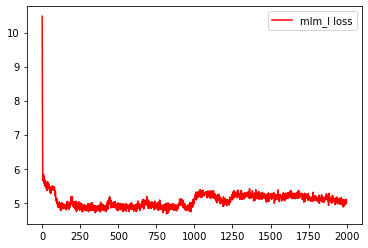

In [189]:
plt.plot(mlm_l_list, color='red', label="mlm_l loss")
plt.legend()
plt.show()

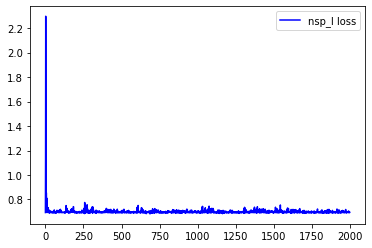

In [190]:
plt.plot(nsp_l_list, color='b', label="nsp_l loss")
plt.legend()
plt.show()

In [193]:
def get_bert_encoding(net, devices, tokens_a, tokens_b=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices).unsqueeze(0)
    segments = torch.tensor(segments, device=devices).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices).unsqueeze(0)
    # encoded_X表示BERT encoder层的是输出
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.0251,  0.9377, -0.0153], device='cuda:0', grad_fn=<SliceBackward0>))

In [195]:
tokens_a = ['a', 'crane', 'is', 'flying']
# 序列长度为6
encoded_text = get_bert_encoding(net, devices, tokens_a)
# 词元序列:'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]  # 第一个词元为"<cls>"
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.0831,  1.2807, -0.6537], device='cuda:0', grad_fn=<SliceBackward0>))

In [194]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, devices, tokens_a, tokens_b)
# 词元序列:'<cls>','a','crane','driver','came','<sep>','he','just', 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([0.0504, 1.4805, 0.0231], device='cuda:0', grad_fn=<SliceBackward0>))